In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline


def calculate_psnr(image1, image2):
    """
    Calculate PSNR between two 2D images.
    
    Parameters:
    - image1: First 2D numpy array
    - image2: Second 2D numpy array
    
    Returns:
    - PSNR value
    """
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if there's no noise
    pixel_max = 255.0  # Assuming pixel values are in the range [0, 255]
    return 20 * np.log10(pixel_max / np.sqrt(mse))

def plotProfile(data, dirx, title="", compare_slice=None):
    """
    Plot a profile slice from a 3D numpy array and optionally compare with another 2D slice.
    
    Parameters:
    - data: 3D numpy array to be sliced and plotted
    - dirx: Slice direction (0, 1, 2, or -1)
    - title: Title of the plot
    - compare_slice: Optional 2D numpy array to compare with
    """
    
    # Validate the direction
    if dirx not in [0, 1, 2, -1]:
        raise ValueError("Slice direction 'dirx' should be [0, 1, 2, -1]")

    # Slice data based on direction
    if dirx == 0:
        loc = data.shape[0] // 2
        slice_data = data[loc, :, :]
        profile = slice_data[slice_data.shape[0] // 2, :]  # Profile across y-axis
    elif dirx == 1:
        loc = data.shape[1] // 2
        slice_data = data[:, loc, :]
        profile = slice_data[slice_data.shape[0] // 2, :]  # Profile across x-axis
    elif dirx == 2:
        loc = data.shape[2] // 2
        slice_data = data[:, :, loc]
        profile = slice_data[slice_data.shape[0] // 2, :]  # Profile across z-axis
    elif dirx == -1:  # When passing a 2D array
        slice_data = data
        profile = slice_data[slice_data.shape[0] // 2, :]

    # Calculate PSNR if compare_slice is provided
    psnr_value = None
    if compare_slice is not None:
        psnr_value = calculate_psnr(slice_data, compare_slice)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the slice
    ax[0].imshow(slice_data, cmap='gray')
    ax[0].axhline(slice_data.shape[0] // 2, linestyle='--', color='red')
    
    # Plot the profile
    ax[1].plot(profile)
    if psnr_value is not None:
        ax[1].set_title(f'Profile (PSNR: {psnr_value:.2f} dB)')
    else:
        ax[1].set_title('Profile')
    
    plt.suptitle(title)
    plt.show()

In [6]:
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from noise2void.dataset import *
from noise2void.model import *
from torch.nn import functional as F
from torchvision import transforms


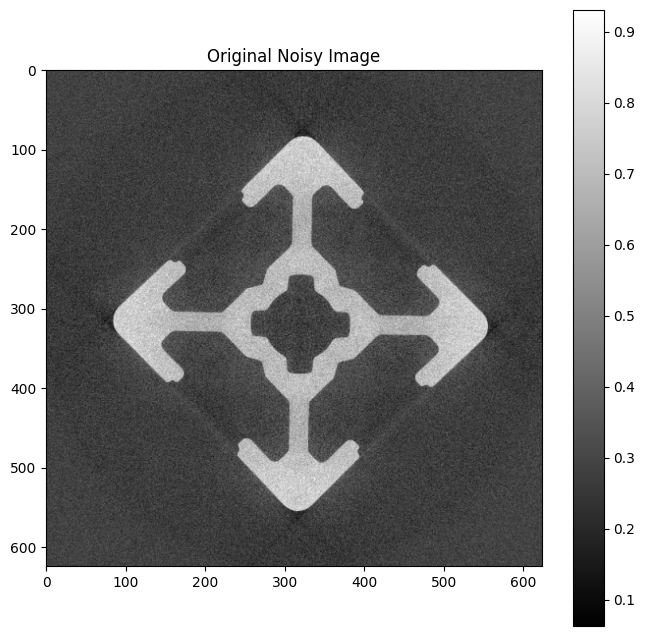

Input shape: (624, 624, 1)


In [4]:
# Load data
input_file = '/lhome/ahmadfn/Paris/data/Bosh/NoisyA/recoNoisyA/downVolume.hdf5'
dataset_name = 'Volume'
slice_index = 250

with h5py.File(input_file, 'r') as f:
    volume = f[dataset_name]
    slice_data = volume[:,slice_index,:]

# Normalize data to [0,1] range
slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min())

# Ensure dimensions are divisible by 16 (for UNet architecture)
target_size = ((slice_data.shape[0] // 16) * 16, (slice_data.shape[1] // 16) * 16)
slice_data = transform.resize(slice_data, target_size)

# Add channel dimension and convert to float32
slice_data = np.expand_dims(slice_data, axis=-1).astype(np.float32)

plt.figure(figsize=(8,8))
plt.imshow(slice_data.squeeze(), cmap='gray')
plt.title('Original Noisy Image')
plt.colorbar()
plt.show()

print(f"Input shape: {slice_data.shape}")

In [7]:
# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patch_size = 64
n_patches = 128
batch_size = 4
learning_rate = 0.001
weight_decay = 0.00001
num_epochs = 300

# Initialize data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset
dataset = Dataset(
    data_dir=None,  # We'll use our own data
    transform=transform,
    sgm=25,  # Noise level estimate
    ratio=0.9,
    size_data=(slice_data.shape[0], slice_data.shape[1], 1),
    size_window=(5, 5)
)

In [8]:
# Initialize model
net = UNet(nch_in=1, nch_out=1, nch_ker=64, norm='bnorm')
net = net.to(device)

# Set up optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

# Convert data to tensor and pad if necessary
input_tensor = torch.from_numpy(slice_data).permute(2, 0, 1).unsqueeze(0)

# Pad input to make dimensions divisible by 16
h, w = input_tensor.shape[2], input_tensor.shape[3]
pad_h = (16 - h % 16) % 16
pad_w = (16 - w % 16) % 16
if pad_h > 0 or pad_w > 0:
    input_tensor = F.pad(input_tensor, (0, pad_w, 0, pad_h), mode='reflect')

input_tensor = input_tensor.to(device)

# Training loop
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = net(input_tensor)
    
    # Calculate loss
    loss = criterion(output, input_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/300], Loss: 0.6314
Epoch [20/300], Loss: 0.1384
Epoch [30/300], Loss: 0.0487
Epoch [40/300], Loss: 0.0263
Epoch [50/300], Loss: 0.0192
Epoch [60/300], Loss: 0.0149
Epoch [70/300], Loss: 0.0124
Epoch [80/300], Loss: 0.0109
Epoch [90/300], Loss: 0.0098
Epoch [100/300], Loss: 0.0089
Epoch [110/300], Loss: 0.0082
Epoch [120/300], Loss: 0.0076
Epoch [130/300], Loss: 0.0071
Epoch [140/300], Loss: 0.0066
Epoch [150/300], Loss: 0.0062
Epoch [160/300], Loss: 0.0058
Epoch [170/300], Loss: 0.0054
Epoch [180/300], Loss: 0.0051
Epoch [190/300], Loss: 0.0049
Epoch [200/300], Loss: 0.0046
Epoch [210/300], Loss: 0.0044
Epoch [220/300], Loss: 0.0042
Epoch [230/300], Loss: 0.0040
Epoch [240/300], Loss: 0.0039
Epoch [250/300], Loss: 0.0037
Epoch [260/300], Loss: 0.0036
Epoch [270/300], Loss: 0.0034
Epoch [280/300], Loss: 0.0033
Epoch [290/300], Loss: 0.0032
Epoch [300/300], Loss: 0.0031


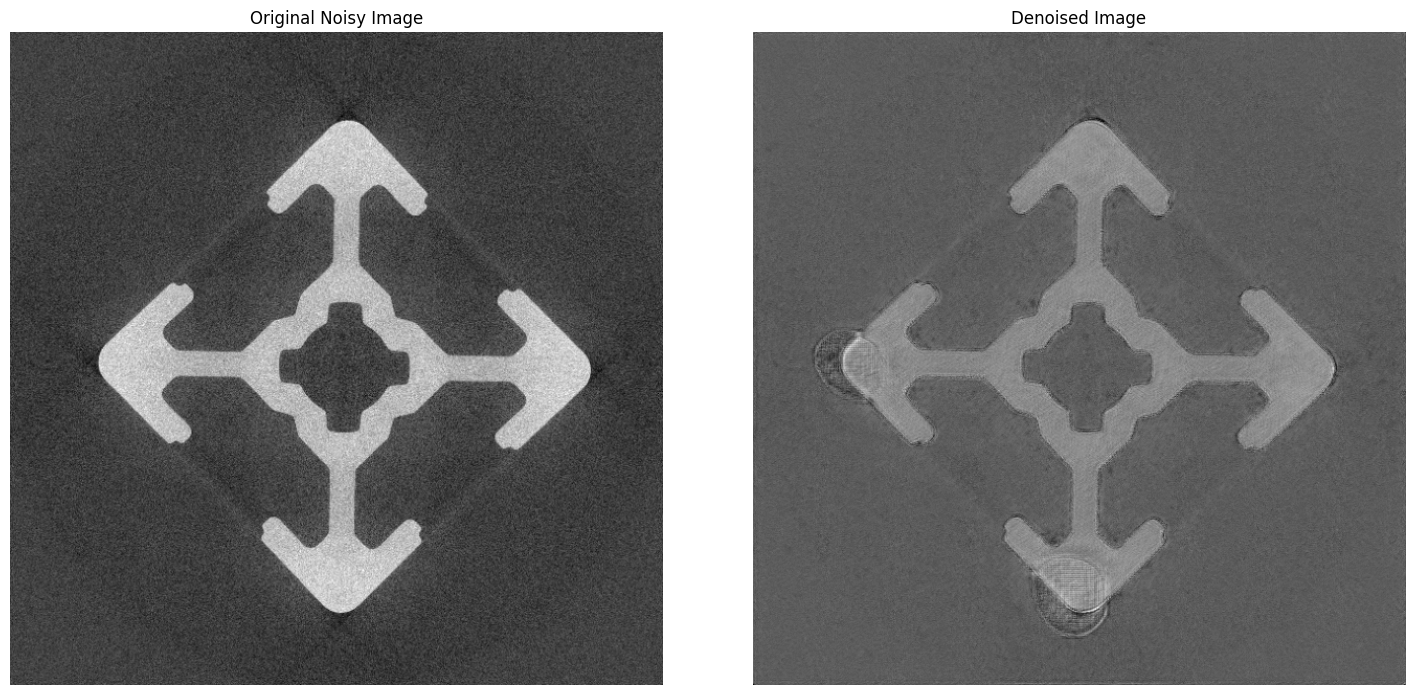

PSNR: 24.95 dB


In [9]:
# Set model to evaluation mode
net.eval()

with torch.no_grad():
    # Get denoised output
    denoised = net(input_tensor)
    
    # Remove padding if added
    if pad_h > 0 or pad_w > 0:
        denoised = denoised[:, :, :h, :w]
    
    # Convert back to numpy
    denoised = denoised.cpu().numpy().squeeze()
    
    # Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    ax1.imshow(slice_data.squeeze(), cmap='gray')
    ax1.set_title('Original Noisy Image')
    ax1.axis('off')
    
    ax2.imshow(denoised, cmap='gray')
    ax2.set_title('Denoised Image')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print PSNR
    mse = np.mean((slice_data.squeeze() - denoised) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    print(f'PSNR: {psnr:.2f} dB')